In [32]:
from marching_cubes import march
import numpy as np
from seaborn import kdeplot
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

import fresnel

from rdkit import Chem
from rdkit.Chem import AllChem

from scipy.spatial.distance import cdist

In [33]:
# mol = Chem.MolFromSmiles('CCCCCC1=CC(=C2C3C=C(CCC3C(OC2=C1)(C)C)C)O')
# mol = Chem.AddHs(mol)
# AllChem.EmbedMolecule(mol)
# conf = mol.GetConformer()
# thc_positions = np.array([list(conf.GetAtomPosition(int(i))) for i in range(mol.GetNumAtoms())])
# thc_positions = (thc_positions - np.mean(thc_positions,0)) + 10
# radii = [Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.GetAtoms()]


In [103]:
def make_vol_sample(numpts, radius):
    ranpts = np.random.uniform(0,radius*2,(numpts,3))-radius
    randist = ((ranpts)**2).sum(1)
    ranpts = ranpts[randist<(radius**2)]
    return ranpts

def golden_spiral(num_pts, radius):
    if radius==0:
        return np.array([[0,0,0]])
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

def make_atom_volume(atomradius, grid_spacing):
    radii = np.linspace(0,atomradius, int(atomradius/(grid_spacing/2))*2)
    numpts= (np.pi*4*radii**2 / (grid_spacing**2)).astype(int)
    pts = np.vstack([golden_spiral(numpts[i], radii[i]) for i in range(numpts.shape[0])])
    return pts

def plotly_scatter(pointsets, sizes):
    data = []
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker={'size': s,'opacity': 0.8,})
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)
    
def fresnel_mesh(vol, n_samples=10, view=None, smooth=0):
    if view is not None:
        view = view
    else:
        view='front'
    vert, norm, faces = march(vol, smooth) 
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

In [45]:
##Set all the useful values:

molecule_volume = 20 #angstroms
grid_spacing = 0.5
grid_size = int(molecule_volume / grid_spacing)
buffer = 5 #angstrom


atomradius = 1.7
proberadius = 1.4
#atomVol = make_vol_sample(1000, atomradius)
#probeVol = make_vol_sample(1000, proberadius)
#atom_and_probeVol = make_vol_sample(1000, atomradius+proberadius)

#For actual molecule:
#atom_and_probeVols = [make_vol_sample(50000, atomradius+proberadius) for atomradius in radii]

In [191]:
molecule_volume = 20 #angstroms
grid_spacing = 0.5
buffer = 5 #angstrom
grid_size = int(np.rint(molecule_volume / grid_spacing) + np.rint(2*buffer/grid_spacing))



In [199]:
n_atoms= 55
atom_centres = np.random.uniform(0,20,(n_atoms,3))

#atom_centres = (atom_centres+buffer)/grid_spacing

In [203]:
np.max((atom_centres+buffer)/grid_spacing)

49.820413217446934

In [202]:
plotly_scatter([(atom_centres+buffer)/grid_spacing, (atom_centres+buffer)/grid_spacing], [10, 2])

In [216]:
a,b,c = np.ones([grid_size, grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b,c]).T
m =cdist(gPoints, atom_centres).min(1)
emp = np.zeros([grid_size, grid_size,grid_size])
emp[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=m
emp = emp-(atomradius+proberadius)


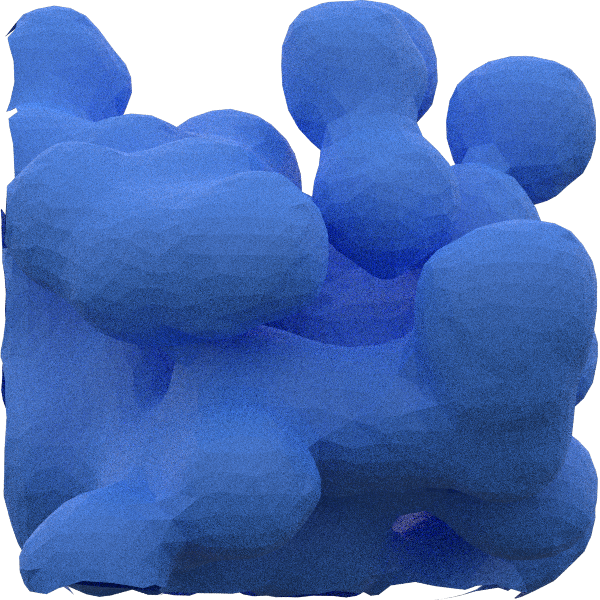

In [218]:
fresnel_mesh(emp+1, n_samples=50, smooth=4)

In [65]:
##Verify that the positions line up:
carbon = make_atom_volume(atomradius,grid_spacing)
expanded_carbon = make_atom_volume(proberadius+atomradius,grid_spacing)
probe = make_atom_volume(proberadius,grid_spacing)


plotly_scatter([carbon, expanded_carbon, probe+np.array([atomradius+proberadius,0,0])], [3,1.5,2])

# Make a grid:

In [92]:
#Make the grid:
grid_size = grid_size + int((2*buffer)/grid_spacing)
grid = np.zeros([grid_size, grid_size, grid_size])

# Make some randomly-placed atoms:
Remember - atoms are expanded by the size of the probe radius! They are actually smaller. 

In [93]:
#make random atom centres:
n_atoms= 55
atom_centres = np.random.uniform(0,20,(n_atoms,3))
#atom_centres = thc_positions.copy()


all_expanded_atoms = list()
#for at, atom_and_probeVol in zip(atom_centres, atom_and_probeVols):
for at in atom_centres:
    stamp = carbon+at
    for st in stamp:
        all_expanded_atoms.append(st)

all_expanded_atoms = np.array(all_expanded_atoms)
#plotly_scatter([all_expanded_atoms], [2])

# Fill in the actual grid values

In [94]:
#Fill in the grid:

#For actual molecules:
#for at, atom_and_probeVol in zip(atom_centres, atom_and_probeVols):

#for testing:
for at in atom_centres:
    stamp = carbon+at+buffer #position of this atom (with buffer included)
    ijk = np.rint(stamp/grid_spacing).astype(int) #as grid points.
    grid[ijk[:,0], ijk[:,1],ijk[:,2]]=1 #set this grid value to 1.

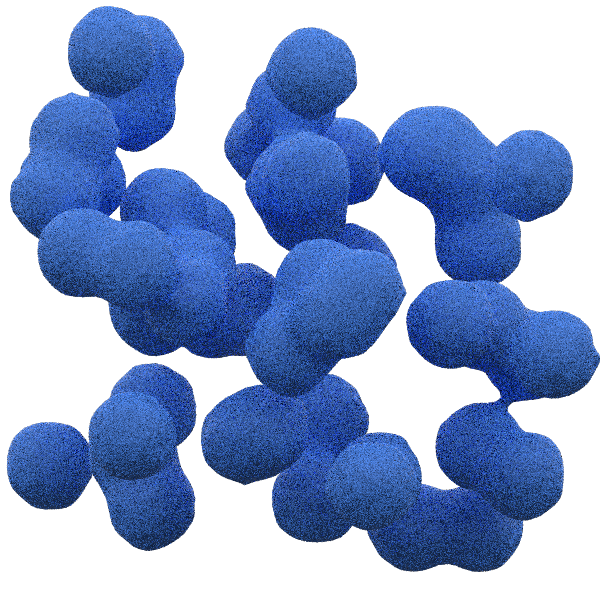

In [95]:
fresnel_mesh(grid)

In [96]:
plotly_scatter([np.vstack(grid.nonzero()).T],[2])

# Now generate (evenly-spaced) surface points around the expanded atoms 

In [97]:
#Remove extra radius.

surface_points = golden_spiral(150, atomradius+proberadius)

#for actual molecule:
#surface_points = [golden_spiral(150)*(atomradius+proberadius) for atomradius in radii]

# and for each of those surface points:
- Remove any that are within the expanded radius of another atom. 
- Fill the volume of the remaining surface points with a probe
- Set all underlying grid values to 0. 

In [98]:
orig_grid = grid.copy()

probe_positions = list()

#for actual molecules:
#for at, surface_point in zip(atom_centres, surface_points):
#for testing:
for at in atom_centres:    
    centre = at+buffer
    surface_stamps = surface_points+centre
    distances = cdist(surface_stamps, atom_centres+buffer).min(1)
    #remove the overlapping surface points:
    surface_stamps = surface_stamps[distances>(atomradius+proberadius-0.01)]    
    #now at each surface point, get a probe volume and set underlying grid points to 0. 
    for sst in surface_stamps:
        probe_positions.append(sst)
        stamp = probe+sst
        ijk = np.rint(stamp/grid_spacing).astype(int) #as grid points.
        grid[ijk[:,0], ijk[:,1],ijk[:,2]]=0 #set this grid value to 0.
probe_positions = np.array(probe_positions)

In [99]:
#plotly_scatter([np.array(probe_positions), all_expanded_atoms+buffer], [2, 1])

In [100]:
plotly_scatter([np.vstack(grid.nonzero()).T],[2])

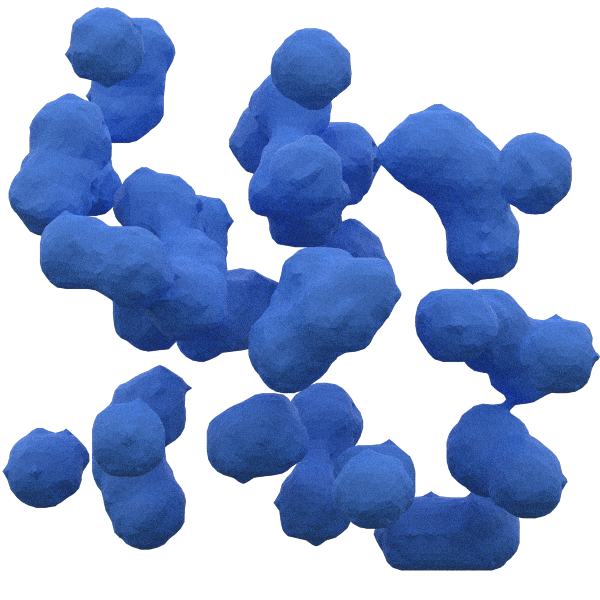

In [105]:
fresnel_mesh(grid, n_samples=100, view='front', smooth=2)